# Quantum Spectral Clustering for Image Segmentation

Image processing algorithms are on the rise. They are used for recognition of objects or features in the image. For example, facial recognition or matching fingerprints [1, 2]. Image segmentation is a sub-area of image processing that tries to distinguish different objects or features from the background.

There are many image segmentation algorithms, but we are going to focus in [3]. Considering quantum computing, there is one algorith that uses the Qauntum Approximate Optimization Algorithm (QAOA) for image segmentation [4]. 

In this chapter we will provide a Quantum Hybrid Algorithm for image segmentation based on normalized cuts. First, we will explain a little bit of spectral clustering and provide an algorithm based on normalized cuts. Then, we will define the Flexible Representation of Quantum Images (FRQI) [5] state to explain a new quantum subroutine for estimating the distance value between pixel values. Finally, we wil provide a small recall of what QAOA is and its use for normalized cuts.


Let us start installing Qiskit on the Google Colab

In [ ]:
pip install qiskit

     |████████████████████████████████| 6.5 MB 5.4 MB/s 
     |████████████████████████████████| 18.0 MB 1.4 MB/s 
     |████████████████████████████████| 238 kB 29.6 MB/s 
     |████████████████████████████████| 200 kB 46.7 MB/s 
     |████████████████████████████████| 54 kB 1.6 MB/s 
     |████████████████████████████████| 1.6 MB 46.7 MB/s 
     |████████████████████████████████| 943 kB 42.1 MB/s 
     |████████████████████████████████| 37.5 MB 1.4 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.6 MB/s 
     |████████████████████████████████| 3.6 MB 11.6 MB/s 
     |████████████████████████████████| 113 kB 46.8 MB/s 
  Created wheel for qiskit: filename=qiskit-0.34.2-py3-none-any.whl size=11805 sha256=d29d40093b061d1dee0bd835410ef06878e90b67ccb308166fe013a69befec48
  Stored in directory: /root/.cache/pip/wheels/62/77/65/cda6eedfdd2a525bd3f479a4386930ae3088a1eb01f8c9

## Spectral clustering

Spectral clustering is a family of clustering algorithms that use eigenvalues and eigenvectors to partition data into different classes. This family of algorithms inherits its name from the spectrum of a matrix, which is the set of its eigenvalues.

Spectral clustering is an unsupervised and transductive family of machine learning algorithms; it is unsupervised because data is not labeled or we do not know it a priori, and it is transductive because it is not usual to use spectral clustering to extend the results to never-seen data points [6].

Basically, spectral clustering algorithms consists on grouping datapoints based on the eigenvectors of a representative matrix. The general algorithm have the following steps:
1. Graph construction:  given $n$ data points, build a similarity graph.
2. Spectral embedding:  given a representative matrix, usually the Laplacian matrix, compute the first $k$ eigenvalues and eigenvectors.
3. Clustering: data is divided into k clusters 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction import image
import scipy.sparse.linalg as sla
from scipy.sparse import coo_matrix

We have the following image and we want to divide it into two dfferent segments:

<Figure size 640x480 with 0 Axes>

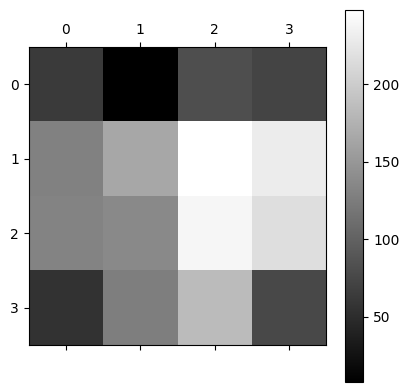

In [2]:
Square = np.array([[63, 8, 82, 72], [129, 165, 248, 230], [131, 137, 239, 217], [55, 127, 184, 76]])
plt.figure()
plt.matshow(Square, cmap=plt.get_cmap('gray'))
plt.colorbar()

We know that there are three different classes, the pixels with blackish values, pixels with gray vlaues and pixels with whitish values. The question is, how does the computer knows how to group those pixels into two different segments?

We could think to segment by certain pixel value, which it is a fanastic idea. However, for more complex images it could be a problem. Or perhaps using a classification algorithm on the image. Nonetheless, some algorithms like KMeans rely on the fact that the pixel values do not have an underlying structure, like an image has.

Let us explain the algorithm. 



### 1. Graph Construction

The first part of any spectral clustering algorithm is Graph Construction. Let us introduce some graph notations and concepts.  

Let $G=(V,E,W)$ be a weighted undirected and connected graph with a set of vertices $V=\{v_1,v_2,\dots,v_n\}$ and a set of edges $E$ such that $e_{ij}=(v_i,v_j)$ an edge exists if the vertex $v_i$ is connected with $v_j$. It is called weighted graph because each edge $e_{ij}$ has a non-negative weight $w_{ij} \geq 0$. As $G$ is an undirected graph, $w_{ij}=w_{ji}$ is satisfied. We denote the adjacency matrix $W$ as:

$$w_{ij} = \left\{\begin{array}{rcl}s_{ij}& \mbox{if} & v_i \mbox{ and }v_j \mbox{ are connected}\\ 0  & \mbox{if} & v_i \mbox{ and }v_j \mbox{ are not connected}\end{array}\right.$$

The similarity measure is a function that calculates the closeness of pairwise data. In our case, we will use the Gaussian Radial Basis Function (RBF). The RBF is defined as:

$$s_{ij}=e^{-\frac{\|x_i-x_j\|_2^2}{\sigma^2}}$$

Where $\|.\|_2$ is the Euclidean distance, $\sigma$ is a parameter that controls the width of the neighborhoods. Usually, $\sigma$ is calculated as the $10-20\%$ of the distance of the two outermost points of the graph [3]. 

If we talk about images, they have an underlying structure. Pixels cannot move, they have a $\textit{rigid}$  neighbors. For example, the graph of our $4\times 4$ image  image should look like

$$\circ-\circ-\circ-\circ$$
$$|\quad\;\,|\quad\;\,|\quad\;\,|$$
$$\circ-\circ-\circ-\circ$$
$$|\quad\;\,|\quad\;\,|\quad\;\,|$$
$$\circ-\circ-\circ-\circ$$
$$|\quad\;\,|\quad\;\,|\quad\;\,|$$
$$\circ-\circ-\circ-\circ$$

where $\circ$ represent the vertices and $|$ or $-$ the edges. Such graph formation is called a 4 neighborhood graph. The center pixel has at most 4 adjacent pixels. Hence, the adjacecny matrix should be a $(4\times4)\times(4\times4)$ matrix. 

The $\textit{weighted}\,$ degree of a vertex, $d_{i}$, is calculated as the sum of the weighted edges incident to $v_i$

$$d_i = \sum_{j=1}^n w_{ij}$$

The Degree matrix has in its diagonal elements the degree of each vertex. Let us define the normalized Laplacian matrix

$$L= D^{-1/2}L_{un}D^{-1/2} =  I - D^{-1/2}WD^{-1/2}$$

The normalized Laplacian matrix is another way to represent a graph. It is a symmetric and positive semidefinite matrix. 

In [17]:
# Initialize the graph with the 4-neighbor graph
graph = image.img_to_graph(Square)

# As Intensities can have values between 0-255, 
#we use the sigma value with 15% of 255
sigma = 255*0.15
graph.data = np.exp(-np.square(graph.data / sigma)/2) # This is called the Kernel Matrix

# Now, let us compute the adjacency Matrix
adjacency = graph.toarray()-np.diag(np.diag(graph.toarray()))
display(adjacency)

# With that info, let us calculate the Degree matrix
degree = np.matrix(np.diag(np.sqrt(np.power(adjacency.sum(axis=1),-1))))

# Now, let us compute the Normalized Laplacian
adjacency_normalized_cuts = np.matmul(degree,np.matmul(adjacency,degree))
L = np.matrix(np.eye(adjacency.shape[0]))-adjacency_normalized_cuts
Laplacian = coo_matrix(L)

array([[0.00000000e+00, 3.55656315e-01, 0.00000000e+00, 0.00000000e+00,
        2.25675262e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.55656315e-01, 0.00000000e+00, 1.53905427e-01, 0.00000000e+00,
        0.00000000e+00, 2.19585554e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.53905427e-01, 0.00000000e+00, 9.66402476e-01,
        0.00000000e+00, 0.00000000e+00, 8.13107204e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.66402476e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.971

### 2. Eigendecomposition
At this stage, we have to calculate the eigenvalues and their corresponding eigenvectors of the normalized Laplacian matrix. With the eigenvectors corresponding to the $k$ smallest eigenvalues, we ensemble the eigenvector matrix $\textit{V}$ with $\textit{n}$ rows and $\textit{k}$ columns.

In [ ]:
# Use the 6 smallest 
eigenvalues, eigenvectors = sla.eigs(Laplacian, 6, which='SM') 

### 3. Clustering
Once the eigenvalues and their corresponding eigenvectors were omputed, we have to calculate the corresponding graph cut. 

$\,$

For a bipartition of the graph, we can cluster the datapoints with the eigenvector corresponding to the second smallest eigenvalue of the Laplacian Matrix. In this work, we use the 0 as the threshold to cluster data points.

When we use the scipy function $\textit{eigs}$ we have to select the smallest eigenvalues and their corrsponding eigenvectors. However, sometimes this function throws the 6 smallest eigenvalues unsorted. Thus, we have to sort the eigenvalues and use the correct eigenvector. 

In [ ]:
# Let us initialize the V matrix with the same number of rows and columns
V = np.zeros(eigenvectors.shape)  # .shape throws the rows and columns
for i in range(eigenvectors.shape[0]): # number of rows
    for j in range(eigenvectors.shape[1]): # number of columns
        if eigenvectors[i,j] > 0:  # above 0 belongs to one cluster
            V[i,j] = 1
        else:
            V[i,j] = 0

# sort the eigenvalues
index = np.argsort(eigenvalues)

Now, let us see the original image and the segmented image 

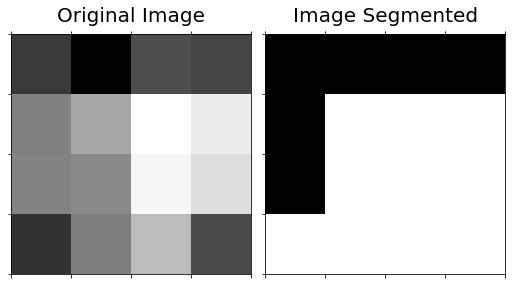

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (7,7), constrained_layout=True, sharey=True)
# show the clusters 
axs[0].matshow(Square, cmap=plt.get_cmap('gray'))
axs[1].matshow(V[:,index[1]].reshape(Square.shape), cmap=plt.get_cmap('gray'))
axs[0].set_title('Original Image', ha="center", va="center", color="k", fontsize=20, fontweight = 'medium')
axs[1].set_title('Image Segmented', ha="center", va="center", color="k", fontsize=20, fontweight = 'medium')
for i in range(2):
  axs[i].set_xticks(np.arange(-0.5,4.5))
  axs[i].set_yticks(np.arange(-0.5,4.5))
  axs[i].set_xticklabels([])
  axs[i].set_yticklabels([])
plt.show()

With the following functions we can know the cut size of the segmented image:

In [3]:
import networkx as nx
import pandas as pd

def compute_edges(adjacency_matrix):
    """
    Function to compute the edges of a graph representation (adjacency matrix)

    Input: 
    - adjacency_matrix: array, 2D array of (pq)*(pq) positions from a p cols and q rows image

    Output: 
    - edges: list, egdes list of the form [(node_1, node_2),...,(node_n, node_n-1)]
             whenever node_n and node_m are neighbors
    """
    edges = [] # Initialize the list
    for row in range(adjacency_matrix.shape[0]):
        for col in range(adjacency_matrix.shape[1]): # for every column and row, do
            if adjacency_matrix[row, col]!=0 and row!=col: # Except when the values of the adj matrix are 0
                edges.append((row, col)) # Append the value of the column and row
    return edges

def create_network(adjacency_matrix, edges):
    """
    Function to create a graph/network from an adjacency matrix and the list of edges

    Input: 
    - adjacency_matrix: array, 2D array of (pq)*(pq) positions from a p cols and q rows image
    - edges: list, egdes list of the form [(node_1, node_2),...,(node_n, node_n-1)]
             whenever node_n and node_m are neighbors

    Output: 
    - working_graph: nx graph
    - number_of_pixels: int, information about how many pixels the image has
    """
    # Identify working pixels
    number_of_pixels = adjacency_matrix.shape[0]

    # Populate a networkx graph with pixels as nodes.
    working_graph = nx.Graph()
    for node in range(number_of_pixels):
        working_graph.add_node(node)

    # Pair up all neighbors with random weights in working_graph.
    for pixel in edges:
        working_graph.add_edge(pixel[0], pixel[1], weight=adjacency_matrix[pixel[0], pixel[1]])

    return working_graph, number_of_pixels

# Compute the size of the cut
def compute_cut_size(labels, graph):
    """
    Function to compute the cut size of a graph given a segmentation list

    Input: 
    - labels: list or 1D array, list of labels/segment
    - graph: nx graph

    Output: 
    - cut_size: int, a number corresponding to the normalized cut size
    """
    A_partition, B_partition = compute_partition_segments(labels, graph)
    cut_size = nx.normalized_cut_size(graph, A_partition, B_partition, weight='weight')
    return cut_size



def compute_partition_segments(labels, graph):
    """
    Given the segmentation in a list and the working graph, thid function computes 
    the list of the 2 subclasses

    Input:
    - labels: list or numpy array, it has the following form [0,1,0,1], where 
              0 belongs to subclass A, and 1 to B
    - graph: nx graph

    Output:
    - A_partition: set, information about which nodes belong to segment A
    - A_partition: set, information about which nodes belong to segment B
    """
    df = pd.Series(labels) # initialize a dataframe with the segment/labels array
    one_qubits = set(df[df==1].index) 
    A_partition = set()
    B_partition = set()

    for node in graph:
        if node in one_qubits:
            # If a one was measured add node to S partition.
            A_partition.add(node)
        else:
            # Otherwise a zero was measured so add to T partition.
            B_partition.add(node)
    return A_partition, B_partition


# edges = compute_edges(adjacency)
# nx_graph, pixels = create_network(adjacency, edges)
# cut_size = compute_cut_size(V[:,index[1]], nx_graph)
# print("Normalized Cut: ", cut_size)

## Quantum Spectral Clustering

In [4]:
from numpy import pi

# importing qiskit libraries 
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble, execute, BasicAer, ClassicalRegister, QuantumRegister
from qiskit.quantum_info.operators import Operator
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_histogram
from qiskit.circuit import Gate, Parameter
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit.library.standard_gates import RYGate

On a similar way, this Quantum Spectral Clustering algorithm is composed by a similar structure. However, we do not use an eigendecomposition of the Laplacian Matrix. 

### 1. Graph Construction

As in the classical Spectral Clustering, we use the normalized adjacency matrix to represent the graph. We use images instead of datapoints, hence we have to use algorithms for image representation. Let us recall the Flexible Representation of Quantum Images (FRQI):

__Definition 1__ The FRQI state is defined as [5]:

$$|I(\theta)\rangle = \frac{1}{2^n}\sum_{i=0}^{2^{2n}-1}(\cos{\theta_i}|0\rangle+\sin{\theta_i}|1\rangle)\otimes |i\rangle$$

where $\theta_i\in\left[0,\frac{\theta}{2}\right]$ for $i=0,1,\dots,2^{2n}-1$ and $n=\log{(columns)}=\log{(rows)}$

The input for such quantum algorithm is a set of angles $\theta =(\theta_1,\theta_2,\dots,\theta_{2^{2n}-1})$.

The FRQI state can be obtained by applying:

1. Haddamard gates such that:
$$\mathcal{H}=I\otimes H^{\otimes 2n}$$
$$\mathcal{H}|0\rangle^{\otimes2n+1}=\frac{1}{\sqrt{2^{2n}}}|0\rangle\otimes\sum_{i=0}^{2^{2n}-1}|i\rangle$$

1. Apply controlled-rotation transform such that:
$$\mathcal{R}=\prod_{i=0}^{2^{2n}-1}\left(R_i\right)$$
where $R_i$ is the controlled rotation gate:
$$R_i=I\otimes\sum_{j=0,j\neq i}^{2^{2n}-1}|j\rangle\langle j|+R_Y(\theta_i)\otimes |i\rangle\langle i|$$
and $R_Y$ is the Y-Rotation gate:
$$R_Y(\theta)=\begin{bmatrix}\cos{\theta/2}&-\sin{\theta/2}\\\sin{\theta/2}&\cos{\theta/2}\end{bmatrix}$$

With this information we can define a new pixel distance estimation. 

__Definition 2__ The Quantum pixel distance estimation is defined as:
$$\mathcal{D}|0\rangle^{\otimes 2n+1}\rightarrow\frac{1}{2^n}\sum_{i=0}^{2^{2n}-1}(\cos{(\theta_i-\vartheta)}|0\rangle+\sin{(\theta_i-\vartheta)}|1\rangle)|i\rangle$$
where $\vartheta$ and $\theta$ are the angles that contain the information about the pixel value. These angles are defined as:
$$\vartheta_j = \frac{\pi}{2}\frac{f'_j}{256} \quad\quad \theta_j = \frac{\pi}{2}\frac{f_j}{256}$$

Measuring this final state enough number of times, we can estimate the rows of the adjacency matrix. 

In [5]:
# This lambda function works to give the n bitstring for all the 2^n states
get_binary_number = lambda x, n: format(x, 'b').zfill(n)

Square_array = Square.flatten()
Square_array

array([ 63,   8,  82,  72, 129, 165, 248, 230, 131, 137, 239, 217,  55,
       127, 184,  76])

In [6]:
graph = image.img_to_graph(Square)
unweighted_adjacency = np.zeros((graph.toarray().shape[0],graph.toarray().shape[0]))
i= 0
for row in graph.toarray():
    j = 0
    for col in row:
        if i != j and col != 0.0:
            unweighted_adjacency[i,j] = 1 
        j += 1
    i += 1
unweighted_adjacency

array([[0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,

In [7]:
def quantum_circuit(circuit, qubits, image_array, row):
    circuit.h(np.arange(qubits-1))

    for col in range(image_array.shape[0]):
        control_state = get_binary_number(col,4)

        RYj = Operator(RYGate(pi/256*Square_array[col]).control(4, label = 'Pixel '+str(col), ctrl_state=control_state))
        RYi = Operator(RYGate(-pi/256*Square_array[row]).control(4, label = 'Pixel '+str(row), ctrl_state=control_state))

        circuit.append(RYi.compose(RYj), range(qubits))
    circuit.measure(range(qubits), range(qubits))
    return circuit

def measure_circuit(backend, n_shots):
    job = backend.run(transpile(qde, backend), shots=n_shots)
    counts = job.result().get_counts()
    return counts

In [8]:
def check_numbers(prob_array):
    count = 0
    for num in prob_array:
        if num > 1:
            prob_array[count] = 1
        count += 1
    return prob_array



def obtain_measurements_and_states_from_counts(counts, measure_array, states_array):
    num = 0
    for bitstring, measure in counts.items():
        measure_array[num] = measure
        states_array[num] = int(bitstring,2)
        num += 1
    return measure_array, states_array



def obtain_probability_array(measure_array, states_array, qubits):
    index = np.argsort(states_array)
    measure_array = measure_array[index]
    prob_array = measure_array*(1/measure_array.sum())
    prob_array = check_numbers((2**(qubits-1))*prob_array[:2**(qubits-1)])
    return prob_array



def retrieve_matrix_from_measurements(qubits, counts):
    measurements = np.array([0 for i in range(len(counts))])
    states_list = [0 for i in range(len(counts))]
    measurements, states_list = obtain_measurements_and_states_from_counts(counts, measurements, states_list)
    prob_array = obtain_probability_array(measurements, states_list, qubits)
    retrieved_image = np.arccos(np.sqrt(prob_array))*512/pi
    return retrieved_image

In [9]:
""" 得到邻接矩阵 """

qubits = 5
backend = QasmSimulator()
qde = QuantumCircuit(qubits, qubits)

adjacency_matrix_list = []
for row in range(graph.toarray().shape[0]):
    qde = QuantumCircuit(qubits, qubits)
    qde = quantum_circuit(qde, 5, Square_array, row)
    counts = measure_circuit(backend, 2**5*100000)
    ret_mat = retrieve_matrix_from_measurements(qubits, counts)
    adjacency_matrix_list.append(ret_mat)

In [10]:
adjacency_matrix_list

[array([  0.        ,  55.21316131,  17.8138874 ,   7.0780284 ,
         66.53955288, 101.97955201, 184.83171794, 166.76894627,
         67.93827693,  73.6533155 , 176.06761866, 153.59683031,
          9.79795265,  64.45929904, 121.50755652,  13.93198302]),
 array([ 53.99687777,   0.        ,  74.338653  ,  64.76813138,
        121.16661502, 156.62747987, 240.1572799 , 221.97793668,
        122.80574019, 129.34052706, 231.07943851, 208.76372533,
         47.24966197, 119.0042803 , 176.04408692,  68.05265844]),
 array([ 19.23136282,  74.13135524,   0.        ,  13.94155865,
         46.29064381,  82.91379816, 165.9351196 , 148.06635549,
         49.26143935,  55.22875761, 157.31591629, 134.65022682,
         28.00340191,  46.03404077, 101.97182756,  11.60852692]),
 array([  6.4798218 ,  63.91430603,   7.30909679,   3.78752983,
         57.55682003,  92.9909975 , 175.82663322, 158.15333376,
         58.63697555,  65.19857796, 167.25461742, 144.77672367,
         15.97294467,  55.27812146

In [10]:
#we use the sigma value with 15% of 255
""" 高斯径向基函数，得到距离与相似度之间的映射 """
sigma = 255*0.15
adjacency_matrix_estimation = np.exp(-np.square(np.array(adjacency_matrix_list) / sigma)/2)
adjacency_matrix_estimation = adjacency_matrix_estimation*unweighted_adjacency
# display(np.round(adjacency_matrix_estimation,3), np.round(adjacency,3))
display(np.round(adjacency_matrix_estimation,3))

array([[0.   , 0.355, 0.   , 0.   , 0.224, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.354, 0.   , 0.156, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.154, 0.   , 0.958, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.986, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.223, 0.   , 0.   , 0.   , 0.   , 0.654, 0.   , 0.   , 0.953,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.632, 0.   , 0.093, 0.   , 0.   ,
        0.749, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.093, 0.   , 0.883, 0.   ,
        0.   , 0.974, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.891, 0.   , 0.   ,
        0.   , 0.   , 0.92

### QAOA for Graph Cut

How do we solve linear programming problems using QAOA? When QAOA was presented by E. Farhi and J. Goldstone [7], they took the maxcut problem as an example. The way to proceed is to take the linear programming problem and restructure it to have no constraints and only binary variables. We call this structure problem as Quadratic Unconstrained Binary Optimization problems. 

QUBO is defined as [8] 

$$\mbox{maximize } \sum_{i\in V}c_{ii}x_i+\sum_{e_{ij}\in E}c_{ij}x_ix_j$$
$$\mbox{subject to } x_i = \{0,1\}^{\otimes n}$$

where $c$ is the cost and $x_i$ is a bitstring of size $n$. 

Why do we use QUBO? Well, using quantum computers, we simulate the objective function to be the energy of the system and find the solution corresponding to the minimum energy. The QUBO formulation is similar the Hamiltonian operator.

The Hamiltonian, in quantum mechanics, is an operator that represents the energy of the system. The mathematical representation of a Hamiltonian is a diagonal matrix of the form:

$$\begin{bmatrix}h_{11}&0&\dots&0\\0&h_{22}&\dots&0\\\vdots&\vdots&\ddots&\vdots\\0&0&\dots&h_{mm}\end{bmatrix}$$

for $n = \log_2(m)$ qubits acting on $m$ states. 

Now, comimg back to the graph cut, we know that the normalized cut is defined as:

$$NCut = Cut(A,B)*\left(\frac{1}{vol(A)}+\frac{1}{vol(B)}\right)$$

This is the objective function (OF) of the graph cut problem. Hence, we can restructure it to write it as a Hamiltonian. The Hamiltonian associated to the $Ncut$ is:

$$NCut=\frac{1}{2}\left(\sum_{e_{ij}\in E}-w_{ij}Z_iZ_j\right)\left(\sum_{m=0}^{m=2^n}|m\rangle\langle m|\left(\frac{1}{vol(A_m)}+\frac{1}{vol(B_m)}\right)\right) = H_AH_B$$

The $NCut$ has two clauses, the $Cut(A,B)$ and the fractional. Let us begin with the _cut_, ie. $H_A$. We know that the _max cut_ problem can be written as the following Hamiltonian (see [QAOA in Qiskit](https://qiskit.org/textbook/ch-applications/qaoa.html#2-Examples:-)):

$$H = \sum_{e_{ij}\in E}\frac{1}{2}w_{ij}(I-Z_iZ_j)$$

where, $H$ is the Hamiltonian, $I = I^{\otimes n}$ is the tensor product of Identity operators for $n$ qubits and $Z_{i}Z_{j} = I\otimes\dots\otimes I\otimes Z_i\otimes I \otimes\dots\otimes I\otimes Z_j\otimes I \otimes \dots I $ the tensor product of Identity gates where $v_i$ and $v_j$ are not neighbors (ie., the weight of the edge is 0) and Pauli Z gates where there exists an edge betwen node $v_i$ and $v_j$.

Hence, if we want a minimum cut, we have to _turn the sign_ of the maximization OF. Thus, 

$$H_A = \frac{1}{2}\sum_{e_{ij}\in E}-w_{ij}Z_iZ_j$$

Let us begin with the coding.

We use vectors instead of matrices to produce the Hamiltonian. This is due two main reasons: 

1. Using matrices, we will finish using matrices of $2^{16}\times2^{16}$, hence it is computationally prohibitive. Even using this Jupyter Notebook in Google Colab.

2. The Identity and Pauli Z operators have information only in its diagonal. If we take their tensor products, only the diagonal will have information. As an example.

$$I\otimes Z=\begin{bmatrix}1&0\\0&1\end{bmatrix}\otimes\begin{bmatrix}1&0\\0&-1\end{bmatrix} = \begin{bmatrix}1&0&0&0\\0&-1&0&0\\0&0&1&0\\0&0&0&-1\end{bmatrix}$$

Hence, the vectors $\overline{I} = \mbox{diag}(I)$ and $\overline{Z} = \mbox{diag}(Z)$ will represent the diagonal of such operators:

$$\overline{I}\otimes \overline{Z}=\begin{bmatrix}1\\1\end{bmatrix}\otimes\begin{bmatrix}1\\-1\end{bmatrix} = \begin{bmatrix}1\\-1\\1\\-1\end{bmatrix}$$

In [11]:
edges = compute_edges(adjacency_matrix_estimation)

In [12]:
# We will use vectors instead of matrices
I = np.array([1,1])
Z = np.array([1,-1])

Hamiltonian_A = 0 # Let us initialize H_A as zero 

for edge in edges: # for every edge in the list of edges
    gates = []  # we initialize the gates list
    if (edge[0] < edge[1]):  # as an undirected graph, we have to only use one direction of the edge
        for qubit in range(16):  # for every qubit
            if (edge[0] == qubit or edge[1] == qubit): # we append Z if the i,j are neighbors
                gates.append(Z)
            else:
                gates.append(I)  # else, we append an I operator 
        kronecker_product = gates[0] 
        for op in range(1,16): 
            kronecker_product = np.kron(kronecker_product, gates[op]) # we apply the tensor product to all gates
        # and finally create the Hamiltonian corresponding to MinCut
        Hamiltonian_A += -adjacency_matrix_estimation[edge[0],edge[1]]*(np.ones(2**16)-kronecker_product) 

Hamiltonian_A

array([ 0.        , -0.03930409, -1.40900702, ..., -1.40900702,
       -0.03930409,  0.        ])

Now we have the OF of the _MinCut_ problem. To normalize and find a balanced solution, we have to apply the _fractional_ clause of the NCUT. 

The bitsring $x_i$ is used in this case to segment the image. For example, if we consider the normalized cut made via _classical_ computation previously, we are in search of the bitstring $|0011001100110011\rangle$ or $|1100110011001100\rangle$. Because, if we rearrange the bits into the $4\times4$ pixels image, then we will have the normalized segmentation.

Hence, every row and column of the Hamiltonian corresponds to a new segmentation. We have to compute the segmentation for every bitstring. We do this with the Degree Matrix, defined as:

$$d_{i} = \sum_i w_ij$$

Let us compute $H_B$

In [13]:
nx_graph, pixels = create_network(adjacency_matrix_estimation, edges)
nx_graph

In [14]:
# Let us compute the second Hamiltonian, H_B
Hamiltonian_B = np.array([0 for i in range(2**16)]).astype(float) # initialize the Hamiltonian B

for state in range(2**16): # for all the 2^16 states
    bitstring = get_binary_number(state,16)
    A_partition, B_partition = compute_partition_segments(bitstring, nx_graph)
    # compute the volume of each subset 
    deg_A, deg_B = nx.volume(nx_graph, A_partition, weight='weight'), nx.volume(nx_graph, B_partition, weight='weight')
    if deg_B == 0: # we consider the case |0000000000000000>, where deg_b=0
        Hamiltonian_B[state] = 1/deg_A
    else:
        if deg_A == 0: # we consider the case |1111111111111111>, where deg_b=0
            Hamiltonian_B[state] = 1/deg_B
        else: 
            Hamiltonian_B[state] = 1/deg_A+1/deg_B

display(Hamiltonian_B.shape[0])
Hamiltonian_B

65536

array([0.04619531, 0.04619531, 0.04619531, ..., 0.04619531, 0.04619531,
       0.04619531])

Now, let us combine $H_A$ and $H_B$ to compute the Hamiltonian assocaited with $NCut$. Once computed the Hamiltonian, we have to compute the evolution operator U, defined as:

$$U = e^{-i\gamma H}$$

where $\gamma$ is the parameter used in QAOA to optimize the algorithm. 

Note: the output of this fiunction is a list because the QISKIT function _Diagonal_ only allows the entry of a list and the listr of the qubits to act on.


In [15]:
def hamiltonian_function(circuit, gamma, H_a, H_b):  
    U_gate_list = []  # we have to provide a list for the Diagonal function
    Hamiltonian = H_a*H_b
    U_gate = np.exp(-complex(0,1)*Hamiltonian*gamma) # compute the evolution of the Hamiltonian
    for state in U_gate:
        U_gate_list.append(state)
    return circuit.diagonal(U_gate_list, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

In [16]:
def compute_expectation(counts, graph):
    """
    Computes expectation value based on measurement results
    Args:
        counts: dict key as bitstring, val as count
        G: networkx graph
    Returns:
        avg: float expectation value
    """
    
    avg = 0
    sum_count = 0

    #Loop over the counts, ie., the bitstrings and their counts
    for bitstring, count in counts.items():
        obj = maxcut_obj(bitstring, graph)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def maxcut_obj(bitstring, graph):
    """
    Given a bitstring as a solution, this function returns the number of edges
    shared between the two partitions of the graph.
    
    Args:
        x: str - solution bitstring
        G: networkx graph
    Returns:
        obj: float - Objective
    """
    obj = 0
    for i, j, w in graph.edges(data=True):
        if bitstring[i] != bitstring[j]:
            obj += w['weight']
            
    return obj


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list - unitary parameters
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(graph.nodes())
    p = len(theta)//2  # number of alternating unitaries, P=1 in this case
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # First, let us prepare the uniform superposition on nqubits
    # which are the nodes
    for i in range(0, nqubits):
        qc.h(i)

    # Now, let us prepare the cost function with RZZ gates between the neighboring
    # nodes u and v. We prepare the RZZ considering the edges weight
    for irep in range(0, p):
        hamiltonian_function(qc, gamma[irep], Hamiltonian_A, Hamiltonian_B)
        #for u, v, w in graph.edges(data=True):  # u and v = pair of nodes, w = weight
        #  if w['weight']!=0: # apply RZZ only if there is a connection betwen u and v
        #    qc.rzz(2 * gamma[irep] * w['weight'], u,v)

        # Now, let us prepare the mixing unitary by applying parameterized X gates 
        for i in range(0, nqubits): # apply parameterized X gates to all the qubits (nodes)
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(graph, p, shots=512):
    """
    Runs parametrized circuit
    Args:
        G: networkx graph
        p: int - Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=2**12).result().get_counts()
        
        return compute_expectation(counts, graph)
    
    return execute_circ

In [17]:
from scipy.optimize import minimize

expectation = get_expectation(nx_graph, p=1) ############# change to a new graph

res = minimize(expectation, [1.0, 1.0], method='COBYLA')
display(res)

backend = BasicAer.get_backend('qasm_simulator') # the device to run on
qaoa_qc  = create_qaoa_circ(nx_graph, res.x)  ############# change to a new graph
# result = backend.run(transpile(qaoa_qc, backend), shots=2**15).result() # 2^14 is the minimum number of shots
result = backend.run(transpile(qaoa_qc, backend), shots=20000).result()
qaoa_counts  = result.get_counts(qaoa_qc)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 4.52179247129577
       x: [ 1.972e+00  1.926e+00]
    nfev: 35
   maxcv: 0.0

In [18]:
qaoa_counts
len(qaoa_counts)

16618

In [20]:
visualization_list = {}
for i in qaoa_counts:
    if qaoa_counts[i] >= 7:
        visualization_list[i] = qaoa_counts[i]

plot_histogram(visualization_list, figsize=(20,10))

StopIteration: 

Now, let us compute the cut size of the solution given by the simulation.

In [21]:
most_frq_btstr = []
value_frq_btstr = 0
for value in visualization_list:
    if visualization_list[value] > value_frq_btstr:
        value_frq_btstr = visualization_list[value]
        most_frq_btstr.append(value)

bit_list = []
for bit in most_frq_btstr[len(most_frq_btstr)-1]:
      bit_list.append(int(bit))

new_graph, pixels = create_network(adjacency_matrix_estimation, edges)
cut_size = compute_cut_size(bit_list, new_graph) #### change to the new graph
print("Normalized Cut Estimation: ", cut_size)

IndexError: list index out of range

# References
[1] A. J. Sanchez-Fernandez et al., "Asynchronous Processing for Latent Fingerprint Identification on Heterogeneous CPU-GPU Systems," in IEEE Access, vol. 8, pp. 124236-124253, 2020, doi: 10.1109/ACCESS.2020.3005476.

[2] D. Valdes-Ramirez et al., "A Review of Fingerprint Feature Representations and Their Applications for Latent Fingerprint Identification: Trends and Evaluation," in IEEE Access, vol. 7, pp. 48484-48499, 2019, doi: 10.1109/ACCESS.2019.2909497.

[3] Jianbo Shi and J. Malik. Normalized cuts and image segmentation. IEEE Trans-actions on Pattern Analysis and Machine Intelligence, 22(8):888–905, 2000.

[4] Lisa Tse, Peter Mountney, Paul Klein, and Simone Severini. Graph cut segmentation methods revisited with a quantum algorithm.CoRR, https://arxiv.org/abs/1812.03050.

[5] Le, P.Q., Dong, F. & Hirota, K. A flexible representation of quantum images for polynomial preparation, image compression, and processing operations. Quantum Inf Process 10, 63–84 (2011). https://doi.org/10.1007/s11128-010-0177-y

[6] Nicolas Tremblay and Andreas Loukas.Approximating  Spectral  Clustering  via Sampling:  A Review, pages 129–183.  Springer International Publishing, Cham,2020.

[7] Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).

[8] Mark Lewis and Fred Glover. Quadratic Unconstrained Binary Optimization Problem Preprocessing:  Theory and Empirical Analysis
